<a href="https://colab.research.google.com/github/Scodingcurriculum/Artificial-Intelligence-C56/blob/main/L22%2623(Lane_Detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade opencv-python

In [ ]:
!pip install opencv-python-headless

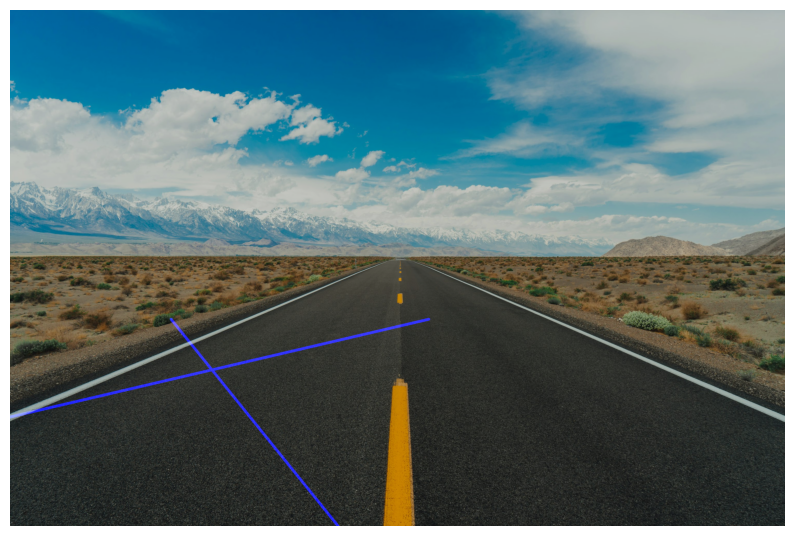

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to apply Canny edge detection
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert image to grayscale
    blur = cv2.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian Blur
    edges = cv2.Canny(blur, 50, 150)  # Apply Canny edge detection
    return edges

# Function to create a mask for the region of interest
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([
        [(200, height), (1100, height), (550, 250)]  # Define the triangle-shaped region
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# Function to display lines on the image
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

# Function to average slope and intercept for lane lines
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:  # Left lane has negative slope
            left_fit.append((slope, intercept))
        else:  # Right lane has positive slope
            right_fit.append((slope, intercept))

    left_fit_avg = np.average(left_fit, axis=0) if left_fit else None
    right_fit_avg = np.average(right_fit, axis=0) if right_fit else None

    left_line = make_coordinates(image, left_fit_avg) if left_fit_avg is not None else None
    right_line = make_coordinates(image, right_fit_avg) if right_fit_avg is not None else None

    return np.array([left_line, right_line]) if left_line is not None and right_line is not None else None

# Function to make coordinates for lane lines
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (3 / 5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

# Main function for lane detection
def lane_detection(image):
    canny_image = canny(image)
    cropped_image = region_of_interest(canny_image)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi / 180, 100, np.array([]), minLineLength=40, maxLineGap=5)

    # Check if lines were detected
    if lines is not None:
        averaged_lines = average_slope_intercept(image, lines)
        if averaged_lines is not None:
            line_image = display_lines(image, averaged_lines)
            combo_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)
            return combo_image
        else:
            print("No averaged lines found.")
            return image
    else:
        print("No lines detected.")
        return image  # Return the original image if no lines are detected

# Load the image (replace 'your_image.jpg' with the path to your image)
image = cv2.imread('newlane.jpeg')
lane_image = np.copy(image)

# Detect lanes
result = lane_detection(lane_image)

# Convert image to RGB for displaying in Matplotlib
result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

# Show the final image with lane lines
plt.figure(figsize=(10,10))
plt.imshow(result_rgb)
plt.axis('off')  # Hide axis
plt.show()